In [1]:
import subprocess
#subprocess.check_call(['python','-m','pip','install','heartpy'])
import heartpy as hp
import math
import matplotlib.pyplot as plt
import neurokit as nk
import pandas as pd
import numpy as np
import random
from scipy.interpolate import interp1d 
from scipy.signal import freqz
from scipy.signal import butter, lfilter

In [2]:
exec(open('ECG_Data.txt').read())

In [3]:
eg=ECG_testdata
eg.head()

,time_sec,ecg_mV
0,0.00000,-0.165000
1,0.00400,-0.047000
2,0.01285,0.388611
3,0.01685,0.623327
4,0.02085,0.805664


In [4]:
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 250 #sampling rate
# remove index column
ec=eg['ecg_mV']
# select subsample of ECG data
eb = ec[0:3500]
# use heartpy to process data
dat, mes = hp.process(eb, 250.0)
# gather peak x and y points
peaklist = dat['peaklist']
ybeat = dat['ybeat']
# Gather features from processed data
mov_avg = dat['rolling_mean']
RR_list = dat['RR_list']
bpm = mes['bpm']

# Frequency Domain Measures
from scipy.interpolate import interp1d #Import the interpolate function from SciPy

RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

# Set variables
n = len(RR_x_new) #Length of the signal
frq = np.fft.fftfreq(n, d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(int(n/2))] #Get single side of the frequency range

# FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(int(n/2))] #Return one side of the FFT

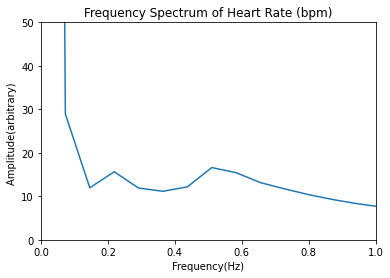

In [5]:
#Plot
plt.title("Frequency Spectrum of Heart Rate (bpm)")
plt.xlim(0,1.0) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude(arbitrary) ")
plt.show()

integrate the area under curve at the LF (0.04 – 0.15Hz) and HF (0.16 – 0.5Hz) frequency bands

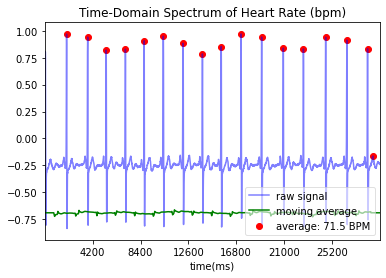

In [6]:
# Plot Time-Domain Spectrum of bpm
plt.title("Time-Domain Spectrum of Heart Rate (bpm)")
plt.xlim(0,3500)
plt.plot(ec, alpha=0.5, color='blue', label="raw signal") #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label="moving average") #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %bpm) #Plot detected peaks
positions = [500,1000,1500,2000,2500,3000]
labels = [4200,8400,12600,16800,21000,25200]
plt.xticks(positions,labels)
plt.xlabel("time(ms)")
plt.legend(loc=4, framealpha=0.6)
plt.show()

In [7]:
lf = np.trapz(abs(Y[(frq>=0.04) & (frq<=0.15)])) #Slice frequency spectrum where x is between 0.04 and 0.15Hz (LF), and use NumPy's trapezoidal integration function to find the area
print("LF:", lf)

hf = np.trapz(abs(Y[(frq>=0.16) & (frq<=0.5)])) #Do the same for 0.16-0.5Hz (HF)
print("HF:", hf)

LF: 20.443815260732656
HF: 36.96274331936551


In [8]:
# bandpass filter 
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

filt=butter_bandpass_filter(eb,20,35,fs)

In [9]:
# contaminate ecg waveform
mix = map(next, random.sample([iter(eb)]*len(eb) + [iter(filt)]*len(filt), len(eb)+len(filt)))

In [10]:
mix = list(mix)
mix = mix[0:3500]
mix = np.array(mix)
mix = (mix-np.min(mix))/(np.max(mix)-np.min(mix))

hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 250 #sampling rate

# use heartpy to process data
dat, mes = hp.process(mix, 250.0)
# gather peak x and y points
peaklist = dat['peaklist']
ybeat = dat['ybeat']
# Gather features from processed data
mov_avg = dat['rolling_mean']
RR_list = dat['RR_list']
bpm = mes['bpm']

# Frequency Domain Measures
RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

# Set variables
n = len(RR_x_new) #Length of the signal
frq = np.fft.fftfreq(n, d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(int(n/2))] #Get single side of the frequency range
frq = (frq-np.min(frq))/(np.max(frq)-np.min(frq))

# FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(int(n/2))] #Return one side of the FFT
Y = (Y-np.min(Y)/(np.max(Y)-np.min(Y)))

/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


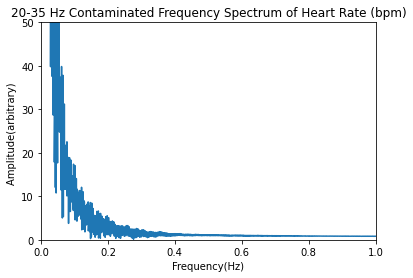

In [11]:
# Plot Contaminated Frequency-Domain
plt.title("20-35 Hz Contaminated Frequency Spectrum of Heart Rate (bpm)")
plt.xlim(0,1.0) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50.0) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude(arbitrary) ")
plt.show()

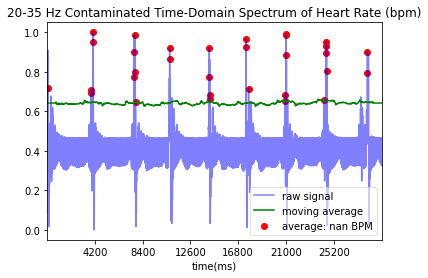

In [12]:
# Plot Contaminated Time-Domain
plt.title("20-35 Hz Contaminated Time-Domain Spectrum of Heart Rate (bpm)")
plt.xlim(0,3500)
plt.plot(mix, alpha=0.5, color='blue', label="raw signal") #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label="moving average") #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %bpm) #Plot detected peaks
positions = [500,1000,1500,2000,2500,3000]
labels = [4200,8400,12600,16800,21000,25200]
plt.xticks(positions,labels)
plt.xlabel("time(ms)")
plt.legend(loc=4, framealpha=0.6)
plt.show()

In [13]:
len(mix)

3500

In [14]:
fs = 250.0
lowcut = 20.0
highcut = 35.0
y = butter_bandpass_filter(mix, lowcut, highcut, fs, order=6)
y = (y-np.min(y))/(np.max(y)-np.min(y))
len(y)

3500

In [15]:
# use heartpy to process data
dat, mes = hp.process(y, 250.0)
# gather peak x and y points
peaklist = dat['peaklist']
ybeat = dat['ybeat']
# Gather features from processed data
mov_avg = dat['rolling_mean']
RR_list = dat['RR_list']
bpm = mes['bpm']

# Frequency Domain Measures
RR_x = peaklist[1:] #Remove the first entry, because first interval is assigned to the second beat.
RR_y = RR_list #Y-values are equal to interval lengths
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

# Set variables
n = len(RR_x_new) #Length of the signal
frq = np.fft.fftfreq(n, d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(int(n/2))] #Get single side of the frequency range
frq = (frq-np.min(frq))/(np.max(frq)-np.min(frq))

# FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(int(n/2))] #Return one side of the FFT
Y = (Y-np.min(Y)/(np.max(Y)-np.min(Y)))

/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


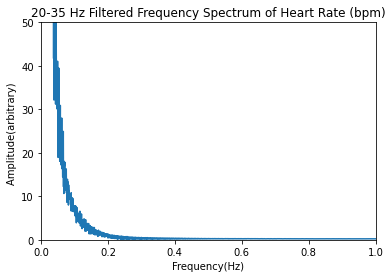

In [16]:
# Plot Filtered Frequency-Domain
plt.title("20-35 Hz Filtered Frequency Spectrum of Heart Rate (bpm)")
plt.xlim(0,1.0) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50.0) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude(arbitrary) ")
plt.show()

In [17]:
mix = list(y)
mix = mix[0:3500]
mix = np.array(mix)
mix = (mix-np.min(mix))/(np.max(mix)-np.min(mix))

hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 250 #sampling rate

# use heartpy to process data
dat, mes = hp.process(mix, 250.0)
# gather peak x and y points
peaklist = dat['peaklist']
ybeat = dat['ybeat']
# Gather features from processed data
mov_avg = dat['rolling_mean']
RR_list = dat['RR_list']
bpm = mes['bpm']


/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/ma/core.py:5215: RuntimeWarning: Mean of empty slice.
  result = super(MaskedArray, self).mean(axis=axis,
/home/max/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


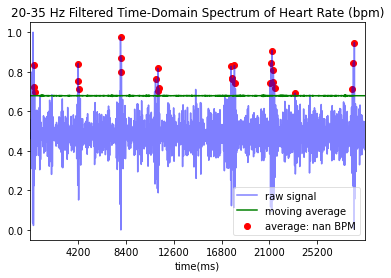

In [18]:
# Plot Filtered Time-Domain
plt.title("20-35 Hz Filtered Time-Domain Spectrum of Heart Rate (bpm)")
plt.xlim(0,3500)
plt.plot(mix, alpha=0.5, color='blue', label="raw signal") #Plot semi-transparent HR
plt.plot(mov_avg, color ='green', label="moving average") #Plot moving average
plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %bpm) #Plot detected peaks
positions = [500,1000,1500,2000,2500,3000]
labels = [4200,8400,12600,16800,21000,25200]
plt.xticks(positions,labels)
plt.xlabel("time(ms)")
plt.legend(loc=4, framealpha=0.6)
plt.show()

De-noising still needs work